### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [1]:
# Import necessary packages
%matplotlib inline
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Helper functions for processing JSONs

In [2]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
  
    try:
        with open(filename, "r") as f:
            data = json.loads(f.read())
    except:
        raise Exception(f"Reading {filename} file encountered an error")
  
    return data

# Function to append records to df
def create_dataframe(data: list) -> pd.DataFrame:

    # Create an empty dataframe to append records
    df = pd.DataFrame()
  
    # Looping through each record
    for d in data:
          
        # Normalize the column levels
        record = pd.json_normalize(d)

        df = pd.concat([df, record], axis=0)
          
    return df

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty df for appending annotations
    directory = "C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/"  # annotation directory
    annos_df = pd.DataFrame()
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # Read the JSON file as python dictionary 
            data = read_json(filename=f)
        
            # Create the dataframe for the array items in annotations key 
            df = create_dataframe(data=data['annotations'])
            df.insert(loc=0, column='img_name', value=f'{f[-30:-5]}.JPG')
        
            df.rename(columns={
                "img_name": "img_name",
                "name": "label",
                "bounding_box.h": "bbox_height",
                "bounding_box.w": "bbox_width",
                "bounding_box.x": "bbox_x_topLeft",
                "bounding_box.y": "bbox_y_topLeft",
                "polygon.paths": "polygon_path"
            }, inplace=True)
            
            # Append the df dataframe to the annos_df dataframe
            annos_df = pd.concat([annos_df, df], ignore_index=True)
        else:
            print(filename)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df.insert(loc=2, column='xmin', 
                    value=annos_df['bbox_x_topLeft'])
    annos_df.insert(loc=3, column='ymin', 
                    value=annos_df['bbox_y_topLeft'])
    annos_df.insert(loc=4, column='xmax', 
                    value=annos_df['bbox_x_topLeft'] + annos_df['bbox_width'])
    annos_df.insert(loc=5, column='ymax', 
                    value=annos_df['bbox_y_topLeft'] + annos_df['bbox_height']) 
  
    # Drop unnecessary columns 
    annos_df = annos_df.drop(columns=['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                      'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

##### Load annotation data into dataframe

In [3]:
# Execute main loading function
if __name__ == '__main__':
    df = main()

##### Filter annotation dataframe

##### Filter images since most annotation class were filtered out

In [4]:
# Store unique img_names in filtered df as array
img_names = df['img_name'].unique().tolist()

# Create a new directory called 'filtered_images'
new_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Copy images in img_names to new directory
for img in img_names:
    shutil.copy2(f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img}', new_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [5]:
# import necessary packages
import numpy as np
from PIL import Image
from collections import defaultdict
from io import BytesIO
from typing import Optional, Callable
import torchvision
torchvision.disable_beta_transforms_warning()
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
cudnn.benchmark = True
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.ops import sigmoid_focal_loss
import utils

##### Pre-process annotation data

In [6]:
# Filter out invalid bounding boxes
df = df[(df['xmin'] < df['xmax']) & (df['ymin'] < df['ymax'])]

# Identify classes with fewer than 200 occurrences as negative classes
class_counts = df['label'].value_counts()
negative_classes = class_counts[class_counts < 200].index.tolist()

# Add 'Hen' to the list of negative classes
if 'Hen' not in negative_classes:
    negative_classes.append('Hen')

# Mark negative classes and 'Hen' as background (0)
df['target'] = df['label'].apply(lambda x: 0 if x in negative_classes else x)

# Convert labels to categorical data and get the numeric codes
df['target'] = pd.Categorical(df['target']).codes

# Create a dictionary using df['label'] as the keys and df['target'] as the values
label_dict = dict(zip(df['target'], df['label']))

# change label_dict key '0' value to 'background'
label_dict[0] = 'NEGATIVE'

# Drop the original 'label' column from df
df = df.drop(['label'], axis=1)

# Rename 'target' column to 'label'
df.rename(columns={'target': 'label'}, inplace=True)

# Save df as csv in directory
df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', index=False)

In [7]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class MAVdroneDataset(torch.utils.data.Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (string): train = True for training transforms
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir

        self.transforms = transforms
        self.unique_image_names = self.df['img_name'].unique()


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.unique_image_names[idx]

        # isolate first row prevents multiple instances of the same image
        row = self.df[self.df['img_name'] == image_name].iloc[0]

        image_path = os.path.join(self.root_dir, row['img_name'])
        image = None

        # ignore corrupted image data during loading else error
        while True:
            with open(image_path, 'rb') as f:
                buff = BytesIO()
                buff.write(f.read())
                buff.seek(0)
                temp_image = np.array(Image.open(buff), dtype = np.uint8)
                image = torch.from_numpy(temp_image).permute(2, 0, 1)

            if image is not None:
                break

        boxes = self.df[self.df['img_name'] == image_name][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == image_name]['label'].values

        labels = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)

        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            
        target = {}
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format = tv_tensors.BoundingBoxFormat.XYXY, canvas_size = (image.shape[1], image.shape[2]))
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        image = tv_tensors.Image(image)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self):
        return len(self.unique_image_names)

##### Data transformation function

In [8]:
def get_transform(train: bool): 
    """
    Args:
        train (bool): Whether the transform is for training or validation/testing.
    """
    transforms_list = []
    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))
    transforms_list.append(T.ToImage())
    transforms_list.append(T.ToDtype(torch.float32, scale=True))
    transforms_list.append(T.Normalize(mean = [0.485, 0.456, 0.406], # ImageNet mean and std deviation 
                                       std = [0.229, 0.224, 0.225])) 
    return T.Compose(transforms_list)

##### Helper functions for plotting image and annotations

In [9]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
bbox_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: bbox_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

##### Plot sample batch to confirm data loads and transforms correctly

In [10]:
# Load sample batch of data to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', 
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images', 
                                transforms = get_transform(train = True))

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 4, shuffle = True, 
                                             collate_fn = utils.collate_fn, num_workers = 0)

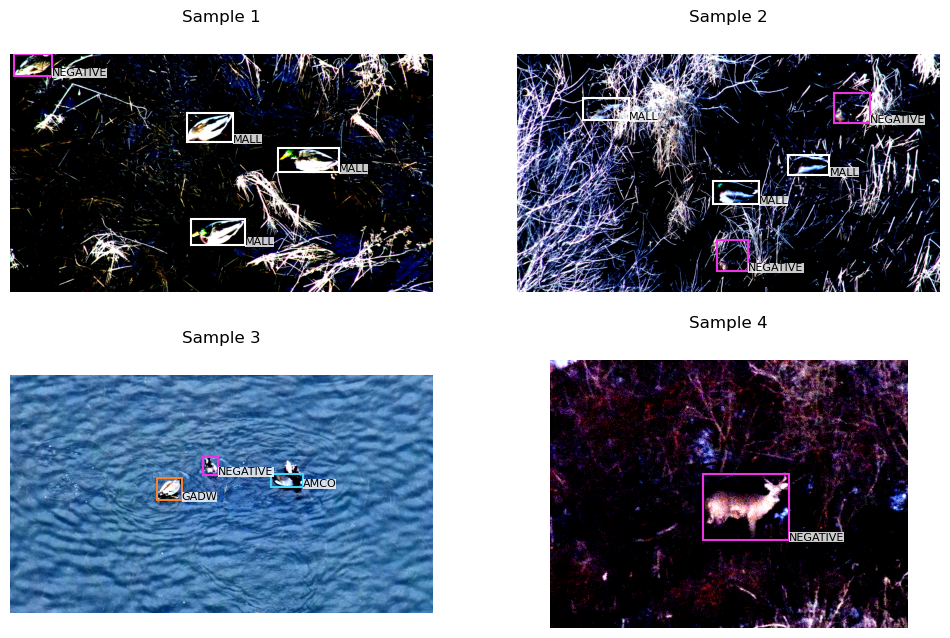

In [11]:
# store images and annotation targets from sample batch
images, targets = next(iter(sample_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

images = [np.clip(image, 0, 1) for image in images]

# Plot the all samples from batch in a grid of subplots.
plt.figure(figsize =(12, int(sample_data_loader.batch_size)*4))
for i in range(int(sample_data_loader.batch_size)):
    ax = plt.subplot(int(sample_data_loader.batch_size), 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

#### Function for loading RetinaNet with custom number of classes and weighted focal loss
##### Adapted from: https://arxiv.org/abs/1708.02002

In [12]:
class CustomRetinaNetClassificationHead(RetinaNetClassificationHead):
    def __init__(self, in_channels, num_anchors, num_classes, alpha=0.25, gamma_loss=2.0, prior_probability=0.01, norm_layer: Optional[Callable[..., nn.Module]] = None):
        super().__init__(in_channels, num_anchors, num_classes, prior_probability, norm_layer)
        self.alpha = alpha
        self.gamma_loss = gamma_loss

    def compute_loss(self, targets, head_outputs, matched_idxs):
        losses = []

        cls_logits = head_outputs["cls_logits"]

        for targets_per_image, cls_logits_per_image, matched_idxs_per_image in zip(targets, cls_logits, matched_idxs):
            # determine only the foreground
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()

            # create the target classification
            gt_classes_target = torch.zeros_like(cls_logits_per_image)
            gt_classes_target[
                foreground_idxs_per_image,
                targets_per_image["labels"][matched_idxs_per_image[foreground_idxs_per_image]],
            ] = 1.0

            # find indices for which anchors should be ignored
            valid_idxs_per_image = matched_idxs_per_image != self.BETWEEN_THRESHOLDS

            # compute the classification loss with custom alpha and gamma_loss
            losses.append(
                sigmoid_focal_loss(
                    cls_logits_per_image[valid_idxs_per_image],
                    gt_classes_target[valid_idxs_per_image],
                    alpha=self.alpha,
                    gamma=self.gamma_loss,
                    reduction="sum",
                )
                / max(1, num_foreground)
            )

        return sum(losses) / len(targets)


def get_retinanet_model(num_classes, alpha=0.5, gamma_loss=3.0, trainable_backbone_layers=3):
    # Load the pre-trained model
    model = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT,
                                      weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT,
                                      trainable_backbone_layers=trainable_backbone_layers)

    # Replace the classification head with the custom one
    in_channels = model.head.classification_head.cls_logits.in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = CustomRetinaNetClassificationHead(in_channels, num_anchors, num_classes, alpha=alpha, gamma_loss=gamma_loss)

    return model

#### Use stratified sampling to split multi-label dataset into train, val, test sets

In [13]:
# Group annotations by image
image_groups = df.groupby('img_name')

# Create a dictionary to store the class distribution for each image
image_class_distribution = {}

# Populate the dictionary with class distributions
for image_name, group in image_groups:
    labels = group['label'].tolist()
    image_class_distribution[image_name] = labels

# Create lists to store the image names for each split
train_images = []
val_images = []
test_images = []

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

# Create a list of all image names
all_images = list(image_class_distribution.keys())

# Shuffle the images
np.random.shuffle(all_images)

# Calculate the number of images for each split
n_train = int(train_ratio * len(all_images))
n_val = int(val_ratio * len(all_images))
n_test = len(all_images) - n_train - n_val

# Split the images
train_images = all_images[:n_train]
val_images = all_images[n_train:n_train + n_val]
test_images = all_images[n_train + n_val:]

# map image names to unique indices
image_to_unique_index = {image: idx for idx, image in enumerate(df['img_name'].unique())}

# Create lists of unique indices for each split
train_indices = [image_to_unique_index[image] for image in train_images]
val_indices = [image_to_unique_index[image] for image in val_images]
test_indices = [image_to_unique_index[image] for image in test_images]

In [14]:
# what percent of class observations are contained in train, val, and test sets
def get_class_distribution(images, image_class_distribution):
    class_counts = defaultdict(int)
    for image in images:
        for label in image_class_distribution[image]:
            class_counts[label] += 1
    return class_counts

train_class_distribution = get_class_distribution(train_images, image_class_distribution)
val_class_distribution = get_class_distribution(val_images, image_class_distribution)
test_class_distribution = get_class_distribution(test_images, image_class_distribution)

class_indices = {label: [] for label in df['label'].unique()}

for idx, row in df.iterrows():
    class_indices[row['label']].append(idx)

train_class_distribution = {k: v / len(class_indices[k]) for k, v in train_class_distribution.items()}
val_class_distribution = {k: v / len(class_indices[k]) for k, v in val_class_distribution.items()}
test_class_distribution = {k: v / len(class_indices[k]) for k, v in test_class_distribution.items()}

print("Train class distribution:", dict(sorted(train_class_distribution.items())))
print("Validation class distribution:", dict(sorted(val_class_distribution.items())))
print("Test class distribution:", dict(sorted(test_class_distribution.items())))

Train class distribution: {0: 0.8260349365877004, 1: 0.779969650986343, 2: 0.8278688524590164, 3: 0.8144690781796966, 4: 0.8340080971659919, 5: 0.8367875647668394, 6: 0.8207885304659498, 7: 0.7723880597014925, 8: 0.815565729234794}
Validation class distribution: {0: 0.12323522373773631, 1: 0.15629742033383914, 2: 0.1418032786885246, 3: 0.11201866977829639, 4: 0.11174089068825911, 5: 0.11139896373056994, 6: 0.11648745519713262, 7: 0.16791044776119404, 8: 0.15304120340091562}
Test class distribution: {0: 0.05072983967456329, 1: 0.0637329286798179, 2: 0.030327868852459017, 3: 0.073512252042007, 4: 0.05425101214574899, 5: 0.05181347150259067, 6: 0.06272401433691756, 7: 0.05970149253731343, 8: 0.031393067364290386}


#### Create weighted random sampler to handle class imbalances during training

In [15]:
# Assuming train_labels is a list of lists, where each list contains the labels for an image
train_labels = [image_class_distribution[image] for image in train_images]

# Flatten the list of lists into a single list of labels
flattened_train_labels = [label for sublist in train_labels for label in sublist]

# Calculate class counts (ignoring background/negative class)
train_class_counts = pd.Series([label for label in flattened_train_labels if label != 0]).value_counts().sort_index().tolist()

# Calculate the total count of labels
train_total_count = sum(train_class_counts)

# Calculate class weights
train_class_weights = [train_total_count / count for count in train_class_counts]
train_class_weights = torch.tensor(train_class_weights, dtype=torch.float32)

# store label weights for each train image 
train_label_weights = [torch.tensor([train_class_weights[label - 1] for label in labels], dtype=torch.float32) for labels in train_labels]

# Calculate the average weight for each image
train_image_weights = [torch.mean(weights).item() for weights in train_label_weights]

In [16]:
train_sampler = torch.utils.data.WeightedRandomSampler(train_image_weights, len(train_image_weights), replacement=True)

### <center>**Tune Model Hyperparameters using Ray Tune**</center> 

In [17]:
from datetime import datetime
import gc
from engine_gradientAccumulation import train_one_epoch, evaluate 
import ray
from ray import train, tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

##### Helper functions for hyperparameter tuning

In [18]:
def train_MAVdroneDataset(config, train_sampler):
    # import inside trainable to avoid pickling errors
    import ray
    from ray import train
    import torch
    import utils
    import tempfile

    # get dataset train and dataloader val from ray object store
    dataset_train = ray.get(config["dataset_train_ref"])
    data_loader_val = ray.get(config["data_loader_val_ref"])
    
    # construct custom retinanet model
    model = get_retinanet_model(num_classes=len(classes), 
                                alpha = config["alpha"], 
                                gamma_loss=config["gamma_loss"],
                                trainable_backbone_layers = int(config["trainable_backbone_layers"]))
    
    device = "cpu" 
    if torch.cuda.is_available():
        device = "cuda:0"
    model.to(device)

    # construct an optimizer 
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr = config["lr"],
                                momentum = config["momentum"], 
                                weight_decay = config["weight_decay"])
    
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size = config["step_size"], # period of lr decay
                                                   gamma = config["gamma_lr"]) # multiplicative factor of lr decay

   # Initialize start_epoch
    start_epoch = 0

    # Load existing checkpoint if exist.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)
            
            # Update start_epoch if loaded checkpoint
            start_epoch = optimizer_state['epoch'] + 1

    # Use gradient accumulation to overcome memory constraints
    training_steps = [
            {"step": 0, "batch_size": config["batch_size"], "epochs": 10, "print_freq": 25, "accumulation_steps": 1},
            {"step": 1, "batch_size": config["batch_size"]*2, "epochs": 10, "print_freq": 10, "accumulation_steps": 2}, 
            {"step": 2, "batch_size": config["batch_size"]*2**2, "epochs": 10, "print_freq": 5, "accumulation_steps": 4},  
            {"step": 3, "batch_size": config["batch_size"]*2**3, "epochs": 10, "print_freq": 2, "accumulation_steps": 8}
        ]

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']

        # use the sampler for weighted sampling to address class imbalances
        data_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, 
                                                  sampler = train_sampler, collate_fn = utils.collate_fn, 
                                                  num_workers = 0, pin_memory = True)
    
        print(f'Beginning training step {step["step"]}... batch size: {batch_size}')

        for epoch in range(start_epoch, num_epochs + start_epoch):
            train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device, 
                                                                     epoch, print_freq, accumulation_steps, 
                                                                     data_loader_val, profiler = None)

            # update the learning rate
            lr_scheduler.step()
            
            # evaluate on the val dataset
            train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader_val, device, data_loader)

            # Here we save a checkpoint. It is automatically registered with Ray Tune
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (model.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = train.Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"train_loss": train_metric_logger.loss.avg,  # metric_logger object
                     "val_loss": val_metric_logger.loss.avg,
                     "train_mAP_50": train_coco_evaluator.coco_eval['bbox'].stats[1],
                     "val_mAP_50": val_coco_evaluator.coco_eval['bbox'].stats[1],
                     "train_mAR_100": train_coco_evaluator.coco_eval['bbox'].stats[8],
                     "val_mAR_100": val_coco_evaluator.coco_eval['bbox'].stats[8],
                     "training_step": step["step"],
                     "epoch": epoch}, 
                    checkpoint=checkpoint
                )

        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch       
    
    print('Tuning Trial Complete!')

# test set accuracy of best model
def test_best_model(best_trial):
    best_model =  get_retinanet_model(num_classes=len(classes), 
                                      alpha = best_trial.config["alpha"], 
                                      gamma_loss=best_trial.config["gamma_loss"],
                                      trainable_backbone_layers = int(best_trial.config["trainable_backbone_layers"]))
                                      
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_model.to(device)

    checkpoint_path = os.path.join(best_trial.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_model.load_state_dict(model_state)

    data_loader_test = ray.get(best_trial.config["data_loader_test_ref"]) 
    
    test_results = evaluate(best_model, data_loader_test, device, train_data_loader=None)

    print(f'Best trial test set mAP_50: {test_results.coco_eval["bbox"].stats[1]} and mAR_100: {test_results.coco_eval["bbox"].stats[8]}')

def trial_dirname_creator(trial):
    return f"train_MAVdroneDataset_{trial.trial_id}"

##### Main Tuning Program

In [ ]:
def main(num_samples, max_num_epochs, train_sampler):

    dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                              root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                              transforms = get_transform(train = True))

    dataset_val = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                  root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                  transforms = get_transform(train = False))
    
    dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                    root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                    transforms = get_transform(train = False))
    
    # subset using a 80/15/5 split for train, validation, and test datasets
    dataset_train = torch.utils.data.Subset(dataset, train_indices)

    dataset_val = torch.utils.data.Subset(dataset_val, val_indices) 

    dataset_test = torch.utils.data.Subset(dataset_test, test_indices) 

    data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                  collate_fn = utils.collate_fn, 
                                                  num_workers = 0, pin_memory = True)
    
    data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, 
                                                    num_workers = 0, pin_memory = True)
    
    # store large datasets in ray object store to reduce overhead
    dataset_train_ref = ray.put(dataset_train)
    data_loader_val_ref = ray.put(data_loader_val)
    data_loader_test_ref = ray.put(data_loader_test)

    
    config = {
        "lr": tune.uniform(0.000009, 0.09),
        "momentum": tune.uniform(0.3, 0.99),
        "weight_decay": tune.uniform(0.00005, 0.2),
        "step_size": tune.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        "gamma_lr": tune.uniform(0.005, 0.5),
        "batch_size": tune.choice([4, 8, 16]),
        "alpha": tune.uniform(0.2, 0.8),
        "gamma_loss": tune.uniform(1.0, 4.0),
        "trainable_backbone_layers": tune.choice([2, 3, 4]),
        "dataset_train_ref": dataset_train_ref,
        "data_loader_val_ref": data_loader_val_ref,
        "data_loader_test_ref": data_loader_test_ref
    }

    algo = TuneBOHB(
        metric="val_mAP_50",
        mode="max",
        points_to_evaluate = [
            {"lr": 0.0005, 
             "momentum": 0.9, 
             "weight_decay": 0.0005, 
             "step_size": 3, 
             "gamma_lr": 0.1,
             "batch_size": 4,
             "alpha": 0.5,
             "gamma_loss": 3.0,
             "trainable_backbone_layers": 3} 
        ] # starting point for search
    )

    algo = tune.search.ConcurrencyLimiter(algo, max_concurrent=1)

    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=int(max_num_epochs),
        reduction_factor=4,
        stop_last_trials=False,
    )
    

    reporter = JupyterNotebookReporter(
        parameter_columns=["lr", "batch_size"],
        metric_columns=["train_loss", "val_loss", "train_mAP_50", "val_mAP_50", "train_mAR_100", "val_mAR_100"]
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_MAVdroneDataset, train_sampler=train_sampler),
            resources={"cpu": 24.0, "gpu": 1.0}
        ),
        run_config=train.RunConfig(
            name="train_MAVdroneDataset_RetinaNet",
            storage_path='C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results',
            stop={"training_iteration": max_num_epochs},
            progress_reporter=reporter,
        ),
        tune_config=tune.TuneConfig(
            metric="val_mAP_50",
            mode="max",
            search_alg = algo,
            scheduler=scheduler,
            num_samples=int(num_samples),
            time_budget_s=600000,
            trial_dirname_creator=trial_dirname_creator
        ),
        param_space=config
    )

    results = tuner.fit()

    best_trial = results.get_best_result("val_mAP_50", "max")

    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
    print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
    print("Best trial final training mAP_50: {}".format(best_trial.metrics["train_mAP_50"]))
    print("Best trial final validation mAP_50: {}".format(best_trial.metrics["val_mAP_50"]))
    print("Best trial final training mAR_100: {}".format(best_trial.metrics["train_mAR_100"]))
    print("Best trial final validation mAR_100: {}".format(best_trial.metrics["val_mAR_100"]))

    test_performance = test_best_model(best_trial)

    return best_trial, test_performance

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    best_trial = main(num_samples = 30, max_num_epochs = 40, train_sampler = train_sampler)

2024-11-17 23:16:15,439	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_MAVdroneDataset pid=5028) Beginning training step 0... batch size: 4
(train_MAVdroneDataset pid=5028) Epoch: [0] Training  [  0/429]  eta: 0:14:31  lr: 0.000002  loss: 2.5023 (2.5023)  classification: 2.2355 (2.2355)  bbox_regression: 0.2668 (0.2668)  time: 2.0305  data: 1.1240  max mem: 4192
(train_MAVdroneDataset pid=5028) Epoch: [0] Training  [ 25/429]  eta: 0:07:09  lr: 0.000031  loss: 2.4249 (2.4397)  classification: 2.2354 (2.2360)  bbox_regression: 0.1907 (0.2037)  time: 1.0112  data: 0.8531  max mem: 4521
(train_MAVdroneDataset pid=5028) Epoch: [0] Training  [ 50/429]  eta: 0:06:30  lr: 0.000060  loss: 2.4454 (2.4426)  classification: 2.2353 (2.2361)  bbox_regression: 0.2097 (0.2065)  time: 0.9945  data: 0.8308  max mem: 4567
(train_MAVdroneDataset pid=5028) Epoch: [0] Training  [ 75/429]  eta: 0:05:53  lr: 0.000089  loss: 2.4153 (2.4361)  classification: 2.2323 (2.2349)  bbox_regression: 0.1813 (0.2012)  time: 0.9389  data: 0.7877  max mem: 4567
(train_MAVdroneDataset p

### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.profiler

def main(best_trial):
    batch_size = best_trial.config["batch_size"]

    training_steps = [
            {"step": 0, "batch_size": batch_size, "epochs": 10, "print_freq": 25, "accumulation_steps": 1},
            {"step": 1, "batch_size": batch_size*2, "epochs": 10, "print_freq": 10, "accumulation_steps": 2}, 
            {"step": 2, "batch_size": batch_size*2**2, "epochs": 10, "print_freq": 5, "accumulation_steps": 4},  
            {"step": 3, "batch_size": batch_size*2**3, "epochs": 10, "print_freq": 2, "accumulation_steps": 8}
        ]

    # load model
    model = get_retinanet_model(num_classes=len(classes), 
                                alpha = best_trial.config["alpha"], 
                                gamma_loss=best_trial.config["gamma_loss"],
                                trainable_backbone_layers = int(best_trial.config["trainable_backbone_layers"]))

    # Set the device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Move the model to the device
    model.to(device)

    start_epoch = 0

    # initialize tensorboard writer in folder named f"{current_datetime}" and using name "RetinaNet"
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}')

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # Initialize the profiler (https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html)
    profiler = torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=3,
            repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(writer.log_dir),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']
    
        # use MAVdroneDataset and defined transformations
        dataset = MAVdroneDataset(csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                  root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                  transforms=get_transform(train=True))
        
        dataset_val = MAVdroneDataset(csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                      root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/',
                                      transforms=get_transform(train=False))

        # subset using a 80/15/5 split for train, validation, and test datasets
        dataset = torch.utils.data.Subset(dataset, train_indices)
        dataset_val = torch.utils.data.Subset(dataset_val, val_indices)

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, 
                                                  collate_fn=utils.collate_fn, num_workers=0,
                                                  pin_memory=True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False,
                                                      collate_fn=utils.collate_fn, num_workers=0,
                                                      pin_memory=True)

        # construct an optimizer - SGD w/ momentum and weight decay
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=best_trial.config["lr"],
                                    momentum=best_trial.config["momentum"], 
                                    weight_decay=best_trial.config["weight_decay"])
        
        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                       step_size=best_trial.config["step_size"],
                                                       gamma=best_trial.config["gamma_lr"])
        
        print(f'Beginning training step {step["step"]}... batch size: {batch_size}')

        #########################################################
        ##               The main training loop                ##
        #########################################################
        with profiler:
            for epoch in range(start_epoch, num_epochs + start_epoch):
                # Monitor memory usage at the start of the epoch
                print(f"Epoch {epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")

                train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device, 
                                                                         epoch, print_freq, accumulation_steps,
                                                                         data_loader_val, profiler)

                # update the learning rate
                lr_scheduler.step()

                # evaluate on the validation dataset
                train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader_val, device, data_loader, profiler)

                # store training and validation metrics in checkpoint dictionary. 
                checkpoint = {
                    "epoch": epoch,
                    "train_loss": train_metric_logger.loss.avg, # average across entire trianing epoch
                    "train_bbox_loss": train_metric_logger.bbox_regression.avg,
                    "train_class_loss": train_metric_logger.classification.avg,
                    "val_loss": val_metric_logger.loss.avg,
                    "val_bbox_loss": val_metric_logger.bbox_regression.avg,
                    "val_class_loss": val_metric_logger.classification.avg,
                    "train_mAP_50": train_coco_evaluator.coco_eval['bbox'].stats[1],
                    "train_mAR_100": train_coco_evaluator.coco_eval['bbox'].stats[8],
                    "val_mAP_50": val_coco_evaluator.coco_eval['bbox'].stats[1],
                    "val_mAR_100": val_coco_evaluator.coco_eval['bbox'].stats[8],
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }

                # append checkpoint to checkpoints list
                checkpoints.append(checkpoint)

                # report training and validation scalars to tensorboard
                writer.add_scalar('Loss/Train', np.array(float(checkpoint["train_loss"])), epoch) # use tags to group scalars
                writer.add_scalar('Loss/Val', np.array(float(checkpoint["val_loss"])), epoch)
                writer.add_scalar('mAP@50/Train', np.array(float(checkpoint["train_mAP_50"])), epoch)
                writer.add_scalar('mAP@50/Val', np.array(float(checkpoint["val_mAP_50"])), epoch)
                writer.add_scalar('mAR@100/Train', np.array(float(checkpoint["train_mAR_100"])), epoch)
                writer.add_scalar('mAR@100/Val', np.array(float(checkpoint["val_mAR_100"])), epoch)

                # Clear CUDA cache and collect garbage to check for memory leaks
                torch.cuda.empty_cache()
                gc.collect()

                # Monitor memory usage at the end of the epoch
                print(f"Epoch {epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")
                print(f"Epoch {epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")

            # set start_epoch to current epoch for next training step
            start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch

    print('All Training Steps Complete!')

    # close tensorboard writer
    writer.close()

    return checkpoints

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()

    # Set environment variable to avoid memory fragmentation
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    
    checkpoints = main(best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest val_mAP_50 value
best_train_epoch = max(checkpoints, key = lambda x: x['val_mAP_50'])

model = get_retinanet_model(num_classes=len(classes), 
                            alpha = best_trial.config["alpha"], 
                            gamma_loss = best_trial.config["gamma_loss"],
                            trainable_backbone_layers = int(best_trial.config["trainable_backbone_layers"])) 

# load model weights from best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), 'RetinaNet_ResNet50_FPN_DuckNet_' + str(datetime.now().strftime("%m%d%Y")) + '.pth')

In [ ]:
# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/checkpoints.txt', 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

### <center>**Model Inference on Test Dataset**</center> 

##### Load the test dataset

In [ ]:
# create dictionary of test indices and image names
test_dict = dict(zip(test_indices, test_images))

# save test_dict to text file just to be safe
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/test_dict.txt', 'w') as f:
    for key, value in test_dict.items():
        f.write('%s:%s\n' % (key, value))

In [ ]:
dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = False))

# subset test dataset using test_indices
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                            collate_fn = utils.collate_fn, num_workers = 0,
                                            pin_memory = True)

In [ ]:
test_performance = evaluate(model, data_loader_test, device=torch.device('cpu'), train_data_loader=None)
print(f'Test set mAP_50: {test_performance.coco_eval["bbox"].stats[1]} and mAR_100: {test_performance.coco_eval["bbox"].stats[8]}')

##### Calculate performance metrics on every image in test dataset

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
results = []

metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100]
                              )

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store per-image test dataset metrics as dataframe

In [ ]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['image_name'] = [result['image_name'] for result in results]
img_results_df['mAP'] = [result['map'].item() for result in results]
img_results_df['mAP_50'] = [result['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# # if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

In [ ]:
# Metric values are running averages in torch metrics, so the last value is the final value.
final_metrics = img_results_df.iloc[-1]
final_metrics = final_metrics.drop('image_name')

##### Print per-image metrics for test dataset as table

In [ ]:
from prettytable import PrettyTable
# create a pretty table object
x = PrettyTable()

cols = ['Metric', 'Value']  

# add column headers
x.field_names = cols

# values for column one in table are column names from final_metrics, column two are the column values. 
for i in range(len(final_metrics)):
    x.add_row([final_metrics.index[i], f'{final_metrics[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/testDataset_image_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/per_image_results_test_dataset.csv', index = False)

##### Store per-class test dataset metrics as dataframe

In [ ]:
class_res_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_df['image_name'] = [result['image_name'] for result in results]
class_res_df['classes'] = [result['classes'] for result in results]
class_res_df['map_per_class'] = [result['map_per_class'] for result in results]
class_res_df['mar_100_per_class'] = [result['mar_100_per_class'] for result in results]

# convert tensors to numpy arrays
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: x.numpy())
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: x.numpy())
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: x.numpy())

# replace integer labels in classes column with labels using label_dict
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# replace -1.0 values in map_per_class and mar_100_per_class with NaN
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

# if map_per_class or mar_100_per_class is NaN, delete value from list. Also delete corresponding class label.
class_res_df['classes'] = class_res_df.apply(lambda x: [i for i, j in zip(x['classes'], x['map_per_class']) if not np.isnan(j)], axis = 1)
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])

In [ ]:
# metric values are running averages in TorchMetrics. Store map and mar from last image in dataset
classes = class_res_df['classes'].iloc[-1]
class_map = class_res_df['map_per_class'].iloc[-1]
class_mar_100 = class_res_df['mar_100_per_class'].iloc[-1]

##### Print per-class metrics for every image in test dataset as table

In [ ]:
# cols = 'value' and all unique classes
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# classes go in first column, class_map in second column, and class_mar_100 in third column
for i in range(len(classes)):
    x.add_row([classes[i], f'{class_map[i]*100:.2f}%', f'{class_mar_100[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/testDataset_class_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
class_res_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/per_class_results_test_dataset.csv', index = False)

##### Load test data into sample batch containing some test images

In [ ]:
# load entire test dataset into one batch
data_loader_test_singleBatch = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

# run predictions on all images in the test dataset
images, targets = next(iter(data_loader_test_singleBatch))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# convert boxes in targets to tensors
targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets) 

##### Post-process model predictions for plotting on original images

In [ ]:
# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    tran_w, tran_h = images[i].shape[1], images[i].shape[2]
    
    images[i] = Image.open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/' + test_images[i])

    orig_w, orig_h = images[i].size


    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([orig_w/tran_w, 
                                                                      orig_h/tran_h, 
                                                                      orig_w/tran_w,
                                                                      orig_h/tran_h]).view(1, 4)

### <center>**Plot Model Predictions for Images in Test Dataset**</center> 

In [ ]:
def plot_bbox_predicted(ax, boxes, labels, scores): # modify plot_bbox to add confidence scores
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox_predicted(ax, box, labels[i], scores[i])

In [ ]:
# Plot 32 samples from batch in a grid of subplots.
plt.figure(figsize = (24, 36))
for i in range(0, 32):
    ax = plt.subplot(8, 4, 1 + i)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], ax = ax)
    plt.axis('off')
    plt.title(test_images[i])

plt.show()

##### Run inference on full dataset to get model estimates of abundance

In [ ]:
dataset_all = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = False))

data_loader_all = torch.utils.data.DataLoader(dataset_all, batch_size = 1, shuffle = False,
                                            collate_fn = utils.collate_fn, num_workers = 0,
                                            pin_memory = True)

# get model predictions for every image in data_loader_all
model_predictions_all = []

for images, targets in data_loader_all:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # append image name to mean_AP
    prediction['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    model_predictions_all.append(prediction)

In [ ]:
# convert model_predictions_all to a dataframe
model_predictions_df = pd.DataFrame(model_predictions_all)

# save csv for comparison with ground truth
model_predictions_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/model_predictions_all.csv', index = False)